In [2]:
import warnings
warnings.filterwarnings('ignore')

import openpyxl
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import svm
import datetime
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import statsmodels.api as sm

import itertools
import optuna

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima_model
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [3]:
wb1 = openpyxl.load_workbook(r"data_sheets\Книга1.xlsx")
sheet = wb1['Лист4']
rcParams['figure.figsize'] = 12, 10

In [4]:
def df_test(frame_col):
    print('Результат теста:')
    df_result = adfuller(frame_col)
    df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for result_value, label in zip(df_result, df_labels):
        print(label + ' : ' + str(result_value))

    if df_result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
        return True
    else:
        print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")
        return False

29982 530


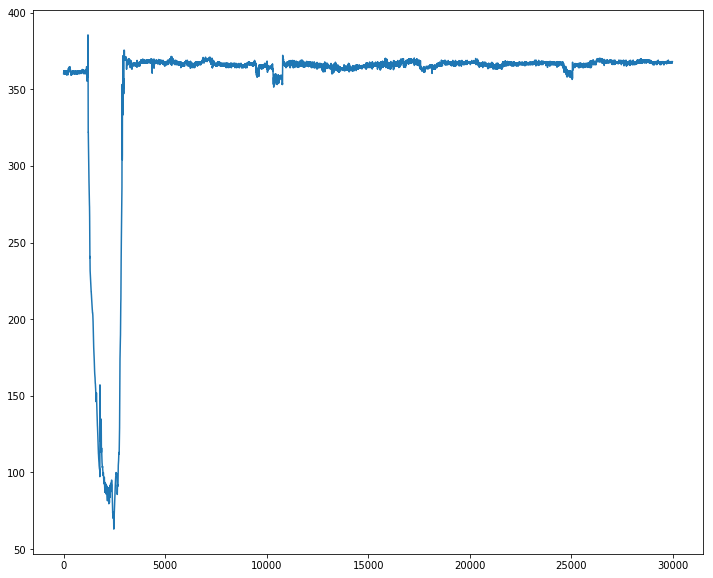

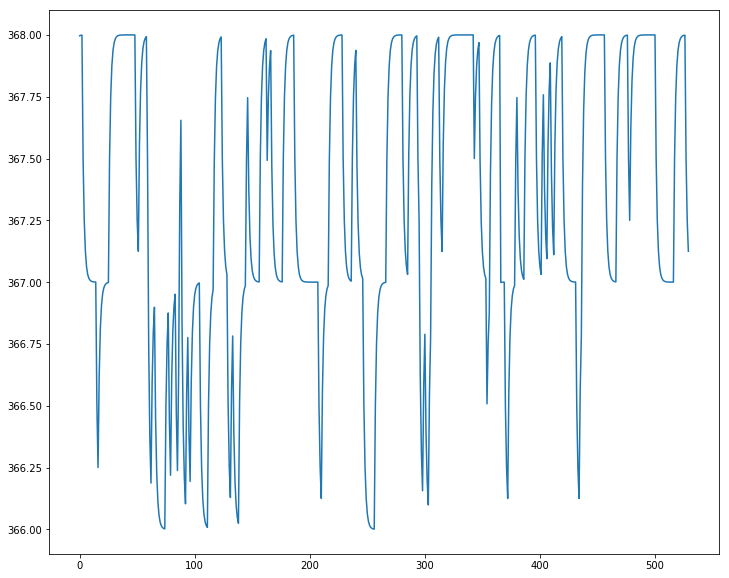

In [5]:
start = datetime.datetime.now()
timer_train = []
timer_test = []
batch_train = []
batch_test = []
n = 18
border = 30000
num = 30530
for i in range (0, border-n):
    timer_train.append(pd.to_datetime((sheet.cell(row = i+n, column = 3).value)))
    batch_train.append(float(sheet.cell(row = i+n, column = 2).value))
    batch_train.append(float(sheet.cell(row = i+n, column = 2).value))
    batch_train.append(float(sheet.cell(row = i+n, column = 2).value))
for j in range (border-n, num-n):
    timer_test.append(pd.to_datetime((sheet.cell(row = i+n, column = 3).value)))
    batch_test.append(float(sheet.cell(row = j+n, column = 2).value))
print(len(batch_train), len(batch_test))
plt.plot(batch_train)
plt.show()
plt.plot(batch_test)
plt.show()

    

In [7]:
df1 =  pd.DataFrame(columns = ["flow1", "time"])
df1.time = timer_train
df1.flow1 = batch_train
print(df_test(df1['flow1']))
df1_diff = df1.diff().dropna()
while(df_test(df1_diff['flow2']) != True):
    df1_diff = df1_diff.diff().dropna()
df1.index = pd.date_range(start='2024-02-01 00:00:00', periods = len(df1['flow1']), freq='min')
df1_diff.index = pd.date_range(start='2024-02-01 00:00:00', periods = len(df1_diff['flow1']), freq='min')
plt.plot(df1['flow1'])

KeyError: 'flow2'

Результат теста:
ADF Test Statistic : -4.041020178812248
p-value : 0.0012103110466835513
#Lags Used : 1
Number of Observations Used : 98
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


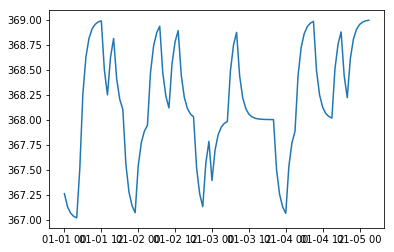

In [7]:
df2 =  pd.DataFrame(columns = ["flow1", "time"])
df2.time = timer_test
df2.flow1 = batch_test
df2_diff = df2.diff().dropna()
while((df_test(df2['flow1']) != True) and (i in range (1, 10))):
    df2_diff = df2_diff.diff().dropna()
df2.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df2['flow1']), freq='h')
df2_diff.index = pd.date_range(start='2024-01-01 00:00:00', periods = len(df2_diff['flow1']), freq='h')
plt.plot(df2['flow1'])

In [14]:
model1 = SARIMAX(df1_diff['flow1'],exog = df2_diff["flow1"], order=(1, 2, 3), seasonal_order=(3, 0, 1, 8), trend = 'c', enforce_invertibility = False)
result1 = model1.fit()

prog_start = 0

pred1 = result1.get_prediction(start = prog_start, dynamic = False)
forecast_values1 = pred1.predicted_mean

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [15]:
difference = np.mean(forecast_values1 - df2_diff['flow1'])
forecast_mse1 = np.sqrt(((forecast_values1 - df2_diff['flow1']) ** 2).mean())
print(forecast_mse1, difference)

0.26396367314354235 0.005562712450716922


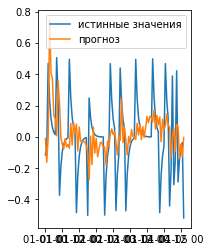

In [16]:
#forecast_mse1 = ((forecast_values1 - batch_test) ** 2).mean()
plt.plot(df1['flow1'])    
figure = pylab.subplot(1,2,2)
figure1 = pylab.plot(df1_diff['flow1'], label = "истинные значения")
figure2 = pylab.plot(forecast_values1, label = "прогноз")
pylab.legend()

In [11]:
def params_optimization(dataset, dataset_test, seasonal, non_seasonal, cycles):
    optimal_params_arr = []
    optimal_seasonal_params_arr = []
    mse_temp = 100
    delta_temp = 10
    print("ARIMA variation")
    for i in range(1, 5):
        for j in range(0, 6):
            for k in range(1, 5):
                non_seasonal = [i, j, k]
                try:
                    model1 = SARIMAX(dataset, exog = dataset_test, order=non_seasonal, seasonal_order=seasonal)
                    result1 = model1.fit(disp = False)
                except:
                    continue
                pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
                forecast_values1 = pred1.predicted_mean
                difference = np.mean(forecast_values1 - dataset_test)
                forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
                if (forecast_mse_temp < mse_temp):
                    optimal_params_arr = [i, j, k]
                    mse_temp = forecast_mse_temp
    print(optimal_params_arr)
    print("number of seasons")
    for i in range (1, cycles):
        seasonal[3] = i
        try:
            model1 = SARIMAX(dataset, exog = dataset_test, order=optimal_params_arr, seasonal_order=seasonal)
            result1 = model1.fit(disp = False)
        except:
            continue
        pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = dataset_test)
        forecast_values1 = pred1.predicted_mean
        difference = np.mean(forecast_values1 - dataset_test)
        forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
        if (forecast_mse_temp < mse_temp):
            optimal_seasonal_params_arr = [1, 1, 1, i]
            mse_temp = forecast_mse_temp
        #print(seasonal, difference, forecast_mse_temp)
    seasons_optimal = optimal_seasonal_params_arr[3]
    print(seasons_optimal)
    print("seasomal parameters")
    
    for i in range(1, 5):
        for j in range(0, 6):
            for k in range(1, 5):
                seasonal = [i, j, k, seasons_optimal]
                try:
                    model1 = SARIMAX(dataset, exog = dataset_test, order=optimal_params_arr, seasonal_order=seasonal)
                    result1 = model1.fit(disp = False)
                    print(optimal_params_arr, seasonal)
                except:
                    continue
                pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
                forecast_values1 = pred1.predicted_mean
                difference = np.mean(forecast_values1 - dataset_test)
                forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
                
                if (forecast_mse_temp < mse_temp):
                    optimal_seasonal_params_arr = seasonal
                    mse_temp = forecast_mse_temp
    return [optimal_params_arr, optimal_seasonal_params_arr, mse_temp]

In [12]:
start = datetime.datetime.now()
params_non_seasonal = [1, 0, 1]
params_seasonal = [1, 0, 1, 10]
print(params_optimization(df1_diff["flow1"], df2_diff['flow1'], params_seasonal, params_non_seasonal, 27))
finish = datetime.datetime.now()
print('Время работы: ' + str(finish - start))

ARIMA variation


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd

C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd

[1, 2, 3]
number of seasons


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\WPy64-3720\python-3.7.2.amd

8
seasomal parameters
[1, 2, 3] [1, 0, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 0, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 0, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 0, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 1, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 1, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 1, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 1, 4, 8]
[1, 2, 3] [1, 2, 1, 8]
[1, 2, 3] [1, 2, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 2, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 2, 4, 8]
[1, 2, 3] [1, 3, 1, 8]
[1, 2, 3] [1, 3, 2, 8]
[1, 2, 3] [1, 3, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 3, 4, 8]
[1, 2, 3] [1, 4, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 4, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 4, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 4, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 5, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 5, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 5, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [1, 5, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 0, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 0, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 0, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 0, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 1, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 1, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 1, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 1, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 2, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 2, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 2, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 2, 4, 8]
[1, 2, 3] [2, 3, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 3, 2, 8]
[1, 2, 3] [2, 3, 3, 8]
[1, 2, 3] [2, 3, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 4, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 4, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 4, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 4, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 5, 1, 8]
[1, 2, 3] [2, 5, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 5, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [2, 5, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 0, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 0, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 0, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 0, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 1, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 1, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 1, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 1, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 2, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 2, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 2, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 2, 4, 8]
[1, 2, 3] [3, 3, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 3, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 3, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 3, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 4, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 4, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 4, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 4, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 5, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 5, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 5, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [3, 5, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 0, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 0, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 0, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 0, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 1, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 1, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 1, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 1, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 2, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 2, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 2, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 2, 4, 8]
[1, 2, 3] [4, 3, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 3, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 3, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 3, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 4, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 4, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 4, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 4, 4, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 5, 1, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 5, 2, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 5, 3, 8]


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[1, 2, 3] [4, 5, 4, 8]
[[1, 2, 3], [3, 0, 1, 8], 0.2495395815130965]
Время работы: 0:19:24.975116


In [13]:
start = datetime.datetime.now()
batch_test = df1_diff['flow1']
batch_train = df2_diff['flow1']

p1 = range(1, 5)
d1 = range(0, 6)
q1 = range(1, 5)
    
ps = range(1, 5)
ds = range(0, 6)
qs = range(1, 5)
s = 5
    
pdq = list(itertools.product(p1, d1, q1))
pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(ps, ds, qs))]
    
def optuna_objective(trial):
    non_seasonal_trial = trial.suggest_categorical('non_seasonal_order', pdq)
    seasonal_trial = trial.suggest_categorical('seasonal_order', pdqs)
    trend = trial.suggest_categorical('trend', ['n', 'c', 't', 'ct', None])
    try:
        model_trial = SARIMAX(batch_train, exog = batch_test, order=non_seasonal_trial, seasonal_order=seasonal_trial)
        result = model_trial.fit(disp = True)
    except:
        return float('inf')
    prediction = result.get_prediction(start = prog_start, dynamic = False, exog = batch_test)
    forecast_values = prediction.predicted_mean
    mse = np.sqrt(((forecast_values - batch_test) ** 2).mean())
    return mse
    
study = optuna.create_study(direction = "minimize")
print(study.optimize(optuna_objective, n_trials = 12))

finish = datetime.datetime.now()
print('Время работы: ' + str(finish - start))   

[I 2024-10-30 13:44:49,435] A new study created in memory with name: no-name-0f8b76c8-adad-48c2-b718-829a80b105e2
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
[I 2024-10-30 13:44:53,432] Trial 0 finished with value: 0.43578070247420736 and parameters: {'non_seasonal_order': (4, 3, 1), 'seasonal_order': (4, 1, 4, 5), 'trend': 'n'}. Best is trial 0 with value: 0.43578070247420736.
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
[I 2024-10-30 13:44:56,813] Trial 1 finished with value: 0.25616500670834436 and parameters: {'non_seasonal_order': (4, 1, 3), 'seasonal_order': (2, 0, 4, 5), 'trend': 't'}. Best is trial 1 with value: 0.25616500670834436.
C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\s

None
Время работы: 0:00:53.055754


In [156]:
difference = np.mean(forecast_values1 - df2_diff['flow1'])
forecast_mse1 = np.sqrt(((forecast_values1 - df2_diff['flow1']) ** 2).mean())
print(forecast_mse1, difference)

0.2720015372407954 -0.007546516235986901
